# Sentiment Analysis Assignment: Analyze Harris / Trump Debate Data

In [2]:
import pandas as pd
import re
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [3]:
# Load the uploaded datasets
harris_df = pd.read_csv("harris_updated_debate.csv")
trump_df = pd.read_csv("trump_updated_debate.csv")

# Display basic information and the first few rows of each dataset for analysis
harris_info = harris_df.info(), harris_df.head()
trump_info = trump_df.info(), trump_df.head()

harris_info, trump_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4791 entries, 0 to 4790
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User ID     4791 non-null   int64  
 1   Tweet ID    4791 non-null   int64  
 2   Tweet       4791 non-null   object 
 3   Created at  4791 non-null   object 
 4   Retweets    4791 non-null   int64  
 5   Replies     4791 non-null   int64  
 6   Likes       4791 non-null   int64  
 7   Quotes      4791 non-null   int64  
 8   Source      0 non-null      float64
dtypes: float64(1), int64(6), object(2)
memory usage: 337.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4795 entries, 0 to 4794
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User ID     4795 non-null   int64  
 1   Tweet ID    4795 non-null   int64  
 2   Tweet       4795 non-null   object 
 3   Created at  4795 non-null   object 
 4   Retweets    4795 non-n

((None,
                 User ID             Tweet ID  \
  0             88236719  1833309413073162489   
  1  1181971448811986944  1833309412951281758   
  2             30477815  1833309412867416555   
  3  1521400102853967872  1833309412649537620   
  4            329687070  1833309412586299739   
  
                                                 Tweet  \
  0  RT @Richard_ezio: I want to tell the truth abo...   
  1  RT @JDVance: It has been 50 days since Kamala ...   
  2  RT @RobSchneider: Good morning, friends.\nJust...   
  3  RT @JamesOKeefeIII: BREAKING: Google Growth St...   
  4  RT @cmclymer: "The Best People"\n\nThis is the...   
  
                    Created at  Retweets  Replies  Likes  Quotes  Source  
  0  2024-09-10 00:59:59+00:00      5150        0      0       0     NaN  
  1  2024-09-10 00:59:59+00:00     29649        0      0       0     NaN  
  2  2024-09-10 00:59:59+00:00     22438        0      0       0     NaN  
  3  2024-09-10 00:59:59+00:00     22376    

# Data Wrangling
Clean the data in the following ways:

- Check for missing values
- Look for consistency of datatypes in all the columns
- Data description
- Data outliers in certain columns
- Visualization

In [5]:
# Descriptive statistics for both datasets
print("Harris Dataset Statistics:")
print(harris_df[['Retweets', 'Replies', 'Likes', 'Quotes']].describe())

print("\nTrump Dataset Statistics:")
print(trump_df[['Retweets', 'Replies', 'Likes', 'Quotes']].describe())


Harris Dataset Statistics:
           Retweets      Replies        Likes       Quotes
count   4791.000000  4791.000000  4791.000000  4791.000000
mean    7707.504488     0.233772     2.630349     0.016489
std    13776.805801    10.654590    88.922584     0.482187
min        0.000000     0.000000     0.000000     0.000000
25%       95.500000     0.000000     0.000000     0.000000
50%     1939.000000     0.000000     0.000000     0.000000
75%     9985.000000     0.000000     0.000000     0.000000
max    98357.000000   734.000000  5291.000000    28.000000

Trump Dataset Statistics:
           Retweets      Replies        Likes       Quotes
count   4795.000000  4795.000000  4795.000000  4795.000000
mean    6758.611679     0.237539     1.847132     0.011053
std    12022.386893    10.654807    77.724795     0.416196
min        0.000000     0.000000     0.000000     0.000000
25%       37.000000     0.000000     0.000000     0.000000
50%     1550.000000     0.000000     0.000000     0.000000
75

In [6]:
# Calculate the percentage of missing values for each column in both datasets
harris_missing_values = (harris_df.isnull().sum() / len(harris_df)) * 100
trump_missing_values = (trump_df.isnull().sum() / len(trump_df)) * 100

# Combine results into a DataFrame for easy comparison
missing_values_df = pd.DataFrame({
    "Harris Dataset (%)": harris_missing_values,
    "Trump Dataset (%)": trump_missing_values
})

# Display the missing values table
missing_values_df.style.format("{:.2f}%").set_caption("Missing Values Percentage")


,Harris Dataset (%),Trump Dataset (%)
User ID,0.00%,0.00%
Tweet ID,0.00%,0.00%
Tweet,0.00%,0.00%
Created at,0.00%,0.00%
Retweets,0.00%,0.00%
Replies,0.00%,0.00%
Likes,0.00%,0.00%
Quotes,0.00%,0.00%
Source,100.00%,100.00%


In [7]:
def detect_potential_bots(df):
    # Define bot-detection logic based on engagement
    # Modify thresholds as necessary
    df['Potential_Bot'] = (
        (df['Retweets'] > 1000) &   # High retweet count
        (df['Replies'] <= 5) &      # Low reply count
        (df['Likes'] <= 5)          # Low like count
    )
    
    # Return only the flagged bots
    return df[df['Potential_Bot']]

# Detect potential bots
potential_bots_harris = detect_potential_bots(harris_df)
potential_bots_trump = detect_potential_bots(trump_df)

# Display results
print("Potential Bots in Harris Dataset:")
display(potential_bots_harris[['User ID', 'Tweet ID', 'Tweet', 'Retweets', 'Replies', 'Likes']])

print("\nPotential Bots in Trump Dataset:")
display(potential_bots_trump[['User ID', 'Tweet ID', 'Tweet', 'Retweets', 'Replies', 'Likes']])


Potential Bots in Harris Dataset:


,User ID,Tweet ID,Tweet,Retweets,Replies,Likes
0,88236719,1833309413073162489,RT @Richard_ezio: I want to tell the truth abo...,5150,0,0
1,1181971448811986944,1833309412951281758,RT @JDVance: It has been 50 days since Kamala ...,29649,0,0
2,30477815,1833309412867416555,"RT @RobSchneider: Good morning, friends.\nJust...",22438,0,0
3,1521400102853967872,1833309412649537620,RT @JamesOKeefeIII: BREAKING: Google Growth St...,22376,0,0
4,329687070,1833309412586299739,"RT @cmclymer: ""The Best People""\n\nThis is the...",3065,0,0
...,...,...,...,...,...,...
4786,16117663,1834019083756413337,"RT @jackplobel: “This weekend, @Swifties4kamal...",4036,0,0
4787,799620697186246656,1834019083563536765,"RT @JoeyMannarinoUS: My mom, no big fan of Tru...",13840,0,0
4788,28769219,1834019083555070031,RT @DefiyantlyFree: Kamala Harris is despicabl...,30912,0,0
4789,1766965755222847488,1834019083466965442,RT @libsoftiktok: UNREAL. Kamala is blaming Tr...,53718,0,0



Potential Bots in Trump Dataset:


,User ID,Tweet ID,Tweet,Retweets,Replies,Likes
0,88236719,1833309413073162489,RT @Richard_ezio: I want to tell the truth abo...,5150,0,0
1,1609990069590568961,1833309412720840970,"RT @RBReich: Over the weekend, Donald Trump th...",4769,0,0
4,1223775310166069249,1833309412506615986,RT @pesach_lattin: So the FBI agent who testif...,8849,0,0
5,361900620,1833309412494282887,"RT @JoshShapiroPA: First, mail ballots haven’t...",17812,0,0
7,1445695271136940039,1833309412414370196,RT @RepJeffries: Why are House Republicans fro...,8216,0,0
...,...,...,...,...,...,...
4782,2496519307,1834019084813340979,RT @AmoneyResists: One thing I noticed that st...,3383,0,0
4783,402060241,1834019084624695464,RT @LeonVaLenciaA: “Nos vamos a volver como Ve...,1233,0,0
4784,297958607,1834019084532678827,"RT @kimrubio21: Donald Trump said he, “probabl...",26015,0,0
4785,833150310524809216,1834019084368765057,RT @BehizyTweets: BREAKING: Former Democrats T...,4025,0,0


In [8]:

def calculate_bot_score(df):
    # Initialize bot score
    df['Bot_Score'] = 0
    
    # 1. Engagement anomaly: High retweets, low replies, and likes
    engagement_anomaly = (df['Retweets'] > 1000) & (df['Replies'] <= 5) & (df['Likes'] <= 5)
    df.loc[engagement_anomaly, 'Bot_Score'] += 2  # High weight due to significant anomaly
    
    # 2. Activity anomaly: Detect accounts with many tweets in a short time (requires datetime conversion)
    df['Created at'] = pd.to_datetime(df['Created at'])
    tweet_frequency = df.groupby('User ID')['Created at'].transform('count')
    df.loc[tweet_frequency > 50, 'Bot_Score'] += 1  # Flag accounts with frequent tweets
    
    # 3. Username anomaly: Detect random digits in usernames
    suspicious_usernames = df['User ID'].astype(str).apply(lambda x: bool(re.search(r'\d{4,}', x)))
    df.loc[suspicious_usernames, 'Bot_Score'] += 1
    
    # 4. Source anomaly: If the 'Source' is NaN (common with bots or unknown apps)
    source_nan = df['Source'].isna()
    df.loc[source_nan, 'Bot_Score'] += 1
    
    # Flag potential bots if bot score exceeds a threshold (e.g., 3)
    df['Potential_Bot'] = df['Bot_Score'] >= 3
    
    return df

# Apply bot detection to both datasets
harris_bots = calculate_bot_score(harris_df)
trump_bots = calculate_bot_score(trump_df)

# Filter to only show potential bots
potential_bots_harris = harris_bots[harris_bots['Potential_Bot']]
potential_bots_trump = trump_bots[trump_bots['Potential_Bot']]

# Display results
print("Potential Bots in Harris Dataset:")
display(potential_bots_harris[['User ID', 'Tweet', 'Retweets', 'Replies', 'Likes', 'Bot_Score']])

print("\nPotential Bots in Trump Dataset:")
display(potential_bots_trump[['User ID', 'Tweet', 'Retweets', 'Replies', 'Likes', 'Bot_Score']])


Potential Bots in Harris Dataset:


,User ID,Tweet,Retweets,Replies,Likes,Bot_Score
0,88236719,RT @Richard_ezio: I want to tell the truth abo...,5150,0,0,4
1,1181971448811986944,RT @JDVance: It has been 50 days since Kamala ...,29649,0,0,4
2,30477815,"RT @RobSchneider: Good morning, friends.\nJust...",22438,0,0,4
3,1521400102853967872,RT @JamesOKeefeIII: BREAKING: Google Growth St...,22376,0,0,4
4,329687070,"RT @cmclymer: ""The Best People""\n\nThis is the...",3065,0,0,4
...,...,...,...,...,...,...
4786,16117663,"RT @jackplobel: “This weekend, @Swifties4kamal...",4036,0,0,4
4787,799620697186246656,"RT @JoeyMannarinoUS: My mom, no big fan of Tru...",13840,0,0,4
4788,28769219,RT @DefiyantlyFree: Kamala Harris is despicabl...,30912,0,0,4
4789,1766965755222847488,RT @libsoftiktok: UNREAL. Kamala is blaming Tr...,53718,0,0,4



Potential Bots in Trump Dataset:


,User ID,Tweet,Retweets,Replies,Likes,Bot_Score
0,88236719,RT @Richard_ezio: I want to tell the truth abo...,5150,0,0,4
1,1609990069590568961,"RT @RBReich: Over the weekend, Donald Trump th...",4769,0,0,4
4,1223775310166069249,RT @pesach_lattin: So the FBI agent who testif...,8849,0,0,4
5,361900620,"RT @JoshShapiroPA: First, mail ballots haven’t...",17812,0,0,4
7,1445695271136940039,RT @RepJeffries: Why are House Republicans fro...,8216,0,0,4
...,...,...,...,...,...,...
4782,2496519307,RT @AmoneyResists: One thing I noticed that st...,3383,0,0,4
4783,402060241,RT @LeonVaLenciaA: “Nos vamos a volver como Ve...,1233,0,0,4
4784,297958607,"RT @kimrubio21: Donald Trump said he, “probabl...",26015,0,0,4
4785,833150310524809216,RT @BehizyTweets: BREAKING: Former Democrats T...,4025,0,0,4


# Cleaning Data

- Dropped unnecessary Source column (100% missing).
- Cleaned Tweets: Removed usernames, URLs, special characters, stopwords, numbers, and applied stemming.
- Detected and noted original languages: Translated non-English tweets and recorded the original language.
- Prepared for sentiment analysis: Cleaned and simplified text for accurate sentiment classification.

In [48]:
import pandas as pd
import re
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Ensure consistent language detection
DetectorFactory.seed = 0

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  # For wordnet lemmatizer
stop_words = set(stopwords.words('english'))

def detect_language(text):
    """ Detects language of the text and returns status. """
    try:
        lang = detect(text)
        if lang == 'en':
            return "original"  # English tweet
        else:
            return f"converted from {lang}"  # Non-English tweet
    except LangDetectException:
        return "unknown"  # Could not detect language

def expand_contractions(text):
    """ Expand common contractions. """
    contractions_dict = {
        "can't": "cannot", "won't": "will not", "I'm": "I am", "you're": "you are",
        "he's": "he is", "she's": "she is", "it's": "it is", "they're": "they are",
        "we're": "we are", "I've": "I have", "you've": "you have", "we've": "we have",
        "they've": "they have", "I'd": "I would", "you'd": "you would", "he'd": "he would",
        "she'd": "she would", "we'd": "we would", "they'd": "they would", "I'll": "I will",
        "you'll": "you will", "he'll": "he will", "she'll": "she will", "we'll": "we will",
        "they'll": "they will", "isn't": "is not", "aren't": "are not", "wasn't": "was not",
        "weren't": "were not", "haven't": "have not", "hasn't": "has not", "hadn't": "had not",
        "won't": "will not", "wouldn't": "would not", "don't": "do not", "doesn't": "does not",
        "didn't": "did not", "can't": "cannot", "couldn't": "could not", "shouldn't": "should not"
    }
    contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
    return contractions_re.sub(lambda x: contractions_dict[x.group(0)], text)

def clean_text(text):
    # Fix encoding issues and expand contractions
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove non-ASCII characters
    text = expand_contractions(text)  # Expand contractions
    
    # Remove URLs, hashtags, mentions, emojis, and special characters
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters

    # Convert to lowercase
    text = text.lower()

    # Tokenize and remove minimal stopwords
    tokens = [word for word in text.split() if word not in stop_words and len(word) > 2]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join cleaned tokens back into text
    return ' '.join(tokens)

def clean_and_separate_tweets(df):
    # Identify retweets and original tweets based on the "RT" prefix
    is_retweet = df['Tweet'].str.startswith('RT')
    
    # Separate retweets and original tweets
    retweets_df = df[is_retweet].copy()
    original_tweets_df = df[~is_retweet].copy()
    
    # Language detection and status assignment
    original_tweets_df['Language_Status'] = original_tweets_df['Tweet'].apply(detect_language)
    retweets_df['Language_Status'] = retweets_df['Tweet'].apply(detect_language)
    
    # Clean both retweets and original tweets
    retweets_df['Cleaned_Tweet'] = retweets_df['Tweet'].apply(clean_text)
    original_tweets_df['Cleaned_Tweet'] = original_tweets_df['Tweet'].apply(clean_text)
    
    return retweets_df, original_tweets_df

# Separate and clean tweets for both datasets
harris_retweets, harris_original_tweets = clean_and_separate_tweets(harris_df)
trump_retweets, trump_original_tweets = clean_and_separate_tweets(trump_df)

# Display first few cleaned tweets for verification
harris_retweets_head = harris_retweets[['Tweet', 'Cleaned_Tweet', 'Language_Status']].head(10)
harris_original_tweets_head = harris_original_tweets[['Tweet', 'Cleaned_Tweet', 'Language_Status']].head(10)
trump_retweets_head = trump_retweets[['Tweet', 'Cleaned_Tweet', 'Language_Status']].head(10)
trump_original_tweets_head = trump_original_tweets[['Tweet', 'Cleaned_Tweet', 'Language_Status']].head(10)

(harris_retweets_head, harris_original_tweets_head, trump_retweets_head, trump_original_tweets_head)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikhi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nikhi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\nikhi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


(                                               Tweet  \
 0  RT @Richard_ezio: I want to tell the truth abo...   
 1  RT @JDVance: It has been 50 days since Kamala ...   
 2  RT @RobSchneider: Good morning, friends.\nJust...   
 3  RT @JamesOKeefeIII: BREAKING: Google Growth St...   
 4  RT @cmclymer: "The Best People"\n\nThis is the...   
 5  RT @DC_Draino: Even CNN can’t believe Kamala w...   
 6  RT @CubanOnlyTrump: JUST ANNOUNCED :Kamala Har...   
 7  RT @DailyCaller: Big Lots Files For Bankruptcy...   
 8  RT @julie_kelly2: This is the only known time ...   
 9  RT @DesireeAmerica4: Who believes Alina Habba ...   
 
                                        Cleaned_Tweet Language_Status  
 0  want tell truth medium eve trumpharris debate ...        original  
 1  day since kamala harris became presumptive nom...        original  
 2  good morning friend reminder bidenharris admin...        original  
 3  breaking google growth strategist expose googl...        original  
 4  best pe

In [50]:
# Column names
print("Column Names in Cleaned Harris Dataset:")
print(cleaned_harris_df.columns.tolist())

print("\nColumn Names in Cleaned Trump Dataset:")
print(cleaned_trump_df.columns.tolist())

# Descriptive statistics for numeric columns
print("\nDescriptive Statistics for Cleaned Harris Dataset:")
print(cleaned_harris_df.describe())

print("\nDescriptive Statistics for Cleaned Trump Dataset:")
print(cleaned_trump_df.describe())

# Descriptive statistics for object/text columns
print("\nDescriptive Statistics for Text Columns in Harris Dataset:")
print(cleaned_harris_df.describe(include='object'))

print("\nDescriptive Statistics for Text Columns in Trump Dataset:")
print(cleaned_trump_df.describe(include='object'))


Column Names in Cleaned Harris Dataset:
['User ID', 'Tweet ID', 'Tweet', 'Created at', 'Retweets', 'Replies', 'Likes', 'Quotes', 'Source', 'Cleaned_Tweet']

Column Names in Cleaned Trump Dataset:
['User ID', 'Tweet ID', 'Tweet', 'Created at', 'Retweets', 'Replies', 'Likes', 'Quotes', 'Source', 'Cleaned_Tweet']

Descriptive Statistics for Cleaned Harris Dataset:
            User ID      Tweet ID      Retweets      Replies        Likes  \
count  4.791000e+03  4.791000e+03   4791.000000  4791.000000  4791.000000   
mean   9.358279e+17  1.833664e+18   7707.504488     0.233772     2.630349   
std    7.247021e+17  2.092158e+14  13776.805801    10.654590    88.922584   
min    8.196930e+05  1.833309e+18      0.000000     0.000000     0.000000   
25%    1.566848e+09  1.833491e+18     95.500000     0.000000     0.000000   
50%    1.217823e+18  1.833657e+18   1939.000000     0.000000     0.000000   
75%    1.588570e+18  1.833845e+18   9985.000000     0.000000     0.000000   
max    1.833986e+18 

In [12]:
# Display the first few rows of the 'Cleaned_Tweet' column from both datasets
cleaned_harris_tweets = cleaned_harris_df['Cleaned_Tweet'].head(10)
cleaned_trump_tweets = cleaned_trump_df['Cleaned_Tweet'].head(10)

cleaned_harris_tweets, cleaned_trump_tweets


(0    want tell truth medium eve trumpharris debate ...
 1    day since kamala harris became presumptive nom...
 2    good morning friend reminder bidenharris admin...
 3    breaking google growth strategist expose googl...
 4    best people vice president harris campaign air...
 5    even cnn cant believe kamala want offer taxpay...
 6    announced kamala harris extended temporary pro...
 7    big lot file bankruptcy inflation continues wr...
 8    known time reporter asked kamala harris januar...
 9    belief alina habba would better first female p...
 Name: Cleaned_Tweet, dtype: object,
 0    want tell truth medium eve trumpharris debate ...
 1    weekend donald trump threatened jail election ...
 2                                    thetrumptrain yes
 3    lie donald trump called abortion ban beautiful...
 4    fbi agent testified link russia trump campaign...
 5    first mail ballot havent even sent yet second ...
 6                               wethepeople many trump
 7    house

# Data Analysis

**Description of the VADER Model**:
VADER (Valence Aware Dictionary and sEntiment Reasoner)

VADER is a rule-based sentiment analysis tool designed specifically for analyzing text in social media, reviews, and other informal contexts.
It uses a lexicon of sentiment-related words (with pre-assigned positive or negative sentiment scores) combined with rules for context analysis.
VADER understands intensifiers (e.g., “very good”), negations (e.g., “not bad”), emojis, exclamation points, and capitalization, making it well-suited for short, informal texts like tweets.

**How VADER Works**:
Lexicon-based scoring: Each word in the input text is matched with the VADER lexicon, and sentiment scores are aggregated.
Compound score: VADER computes a compound score ranging from -1 (most negative) to +1 (most positive) to determine the overall sentiment.
Sentiment is classified into:
Positive: Compound score > 0.05
Neutral: -0.05 ≤ Compound score ≤ 0.05
Negative: Compound score < -0.05

In [52]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    """
    Analyzes sentiment using VADER and returns the compound score and classification.
    """
    sentiment_scores = analyzer.polarity_scores(text)
    compound = sentiment_scores['compound']
    
    # Classify sentiment based on compound score
    if compound > 0.05:
        sentiment = 'Positive'
    elif compound < -0.05:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'
    
    return compound, sentiment

def perform_sentiment_analysis(df):
    # Apply VADER sentiment analysis to the cleaned tweets
    results = df['Cleaned_Tweet'].apply(analyze_sentiment)
    
    # Create separate columns for compound score and sentiment classification
    df['Sentiment_Score'] = [score for score, sentiment in results]
    df['Sentiment'] = [sentiment for score, sentiment in results]
    
    return df

# Perform sentiment analysis on retweets and original tweets for both Harris and Trump datasets
harris_retweets = perform_sentiment_analysis(harris_retweets)
harris_original_tweets = perform_sentiment_analysis(harris_original_tweets)
trump_retweets = perform_sentiment_analysis(trump_retweets)
trump_original_tweets = perform_sentiment_analysis(trump_original_tweets)

# Display sentiment distribution for each category
harris_retweets_distribution = harris_retweets['Sentiment'].value_counts()
harris_original_tweets_distribution = harris_original_tweets['Sentiment'].value_counts()
trump_retweets_distribution = trump_retweets['Sentiment'].value_counts()
trump_original_tweets_distribution = trump_original_tweets['Sentiment'].value_counts()

(harris_retweets_distribution, harris_original_tweets_distribution, 
 trump_retweets_distribution, trump_original_tweets_distribution)



(Sentiment
 Negative    1583
 Positive    1479
 Neutral     1029
 Name: count, dtype: int64,
 Sentiment
 Negative    266
 Positive    224
 Neutral     210
 Name: count, dtype: int64,
 Sentiment
 Negative    1464
 Positive    1346
 Neutral     1122
 Name: count, dtype: int64,
 Sentiment
 Negative    326
 Positive    310
 Neutral     227
 Name: count, dtype: int64)

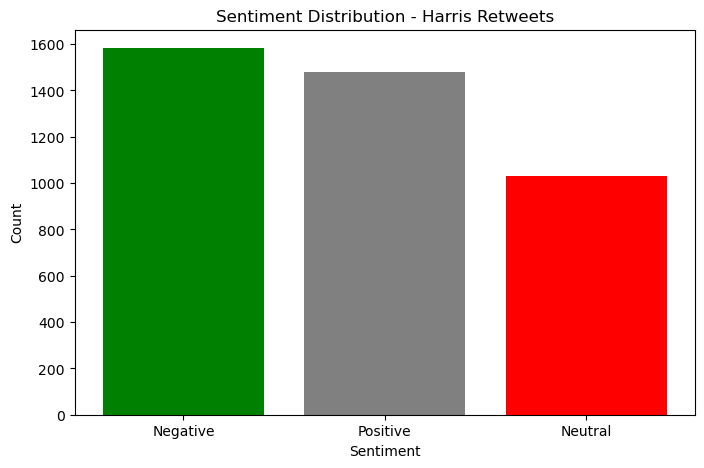

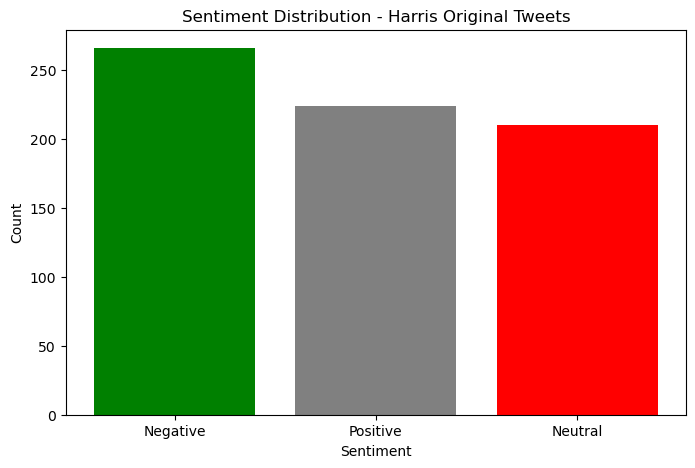

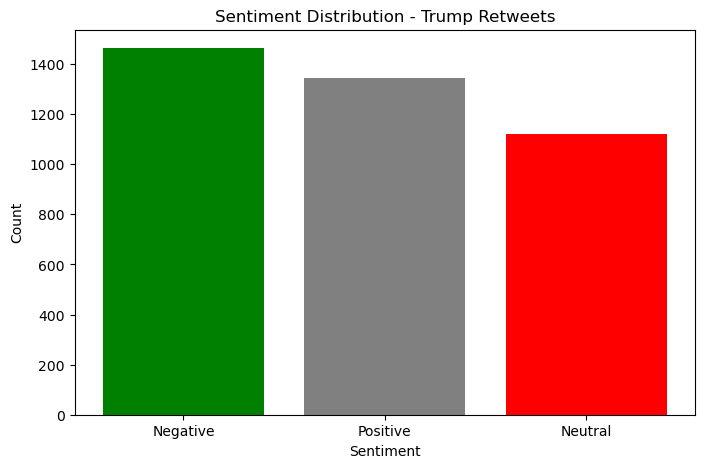

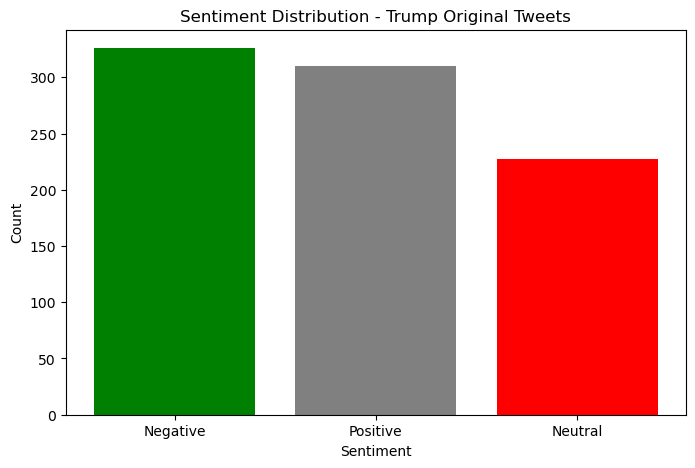

In [56]:
import matplotlib.pyplot as plt

def plot_sentiment_distribution(df, title):
    # Get sentiment counts
    sentiment_counts = df['Sentiment'].value_counts()
    
    # Plot the bar chart
    plt.figure(figsize=(8, 5))
    plt.bar(sentiment_counts.index, sentiment_counts.values, color=['green', 'gray', 'red'])
    plt.title(f'Sentiment Distribution - {title}')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.show()

# Plot sentiment distribution for Harris Retweets and Original Tweets
plot_sentiment_distribution(harris_retweets, "Harris Retweets")
plot_sentiment_distribution(harris_original_tweets, "Harris Original Tweets")

# Plot sentiment distribution for Trump Retweets and Original Tweets
plot_sentiment_distribution(trump_retweets, "Trump Retweets")
plot_sentiment_distribution(trump_original_tweets, "Trump Original Tweets")



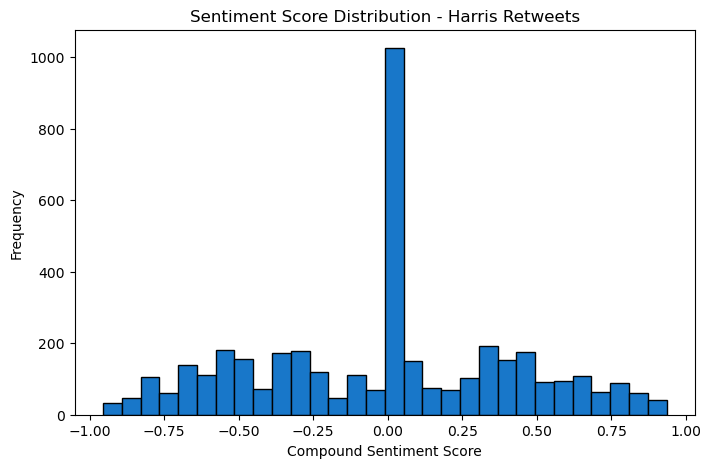

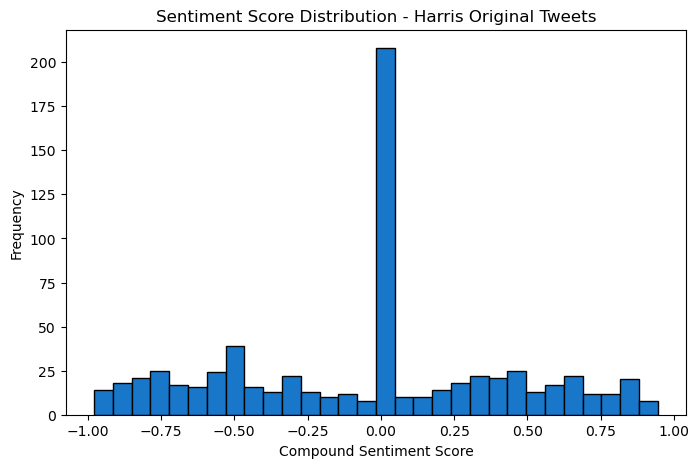

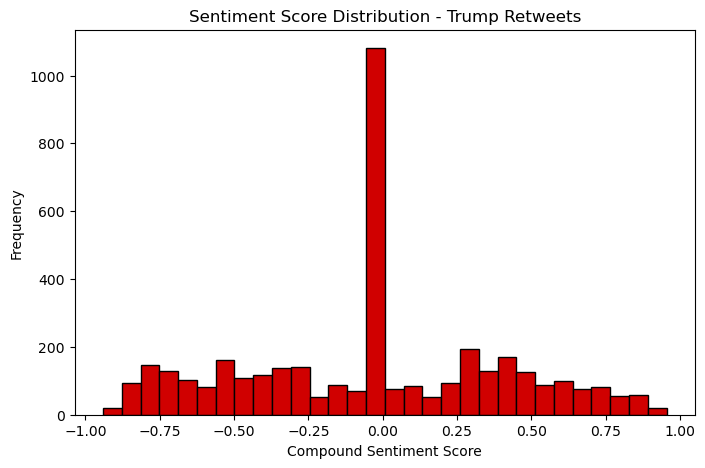

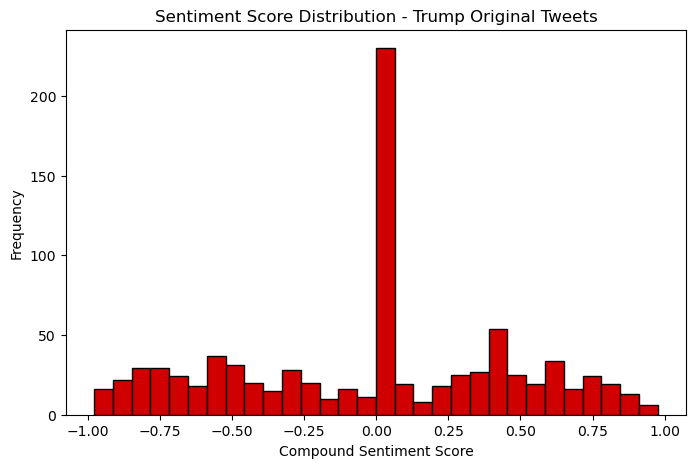

In [58]:
import matplotlib.pyplot as plt

def plot_and_save_sentiment_histogram(df, title, color, filename):
    # Plot histogram of sentiment scores
    plt.figure(figsize=(8, 5))
    plt.hist(df['Sentiment_Score'], bins=30, color=color, edgecolor='black')
    plt.title(f'Sentiment Score Distribution - {title}')
    plt.xlabel('Compound Sentiment Score')
    plt.ylabel('Frequency')
    
    # Save the plot as a PNG file
    plt.savefig(f"{filename}.png", format='png', dpi=300, bbox_inches='tight')
    plt.show()  # Display the plot in the notebook
    plt.close()  # Close the figure to free memory

# Save and display histograms for both retweets and original tweets for Harris and Trump

# Harris Retweets
plot_and_save_sentiment_histogram(harris_retweets, "Harris Retweets", color='#1877C9', filename='harris_retweets_sentiment_histogram')

# Harris Original Tweets
plot_and_save_sentiment_histogram(harris_original_tweets, "Harris Original Tweets", color='#1877C9', filename='harris_original_tweets_sentiment_histogram')

# Trump Retweets
plot_and_save_sentiment_histogram(trump_retweets, "Trump Retweets", color='#D00000', filename='trump_retweets_sentiment_histogram')

# Trump Original Tweets
plot_and_save_sentiment_histogram(trump_original_tweets, "Trump Original Tweets", color='#D00000', filename='trump_original_tweets_sentiment_histogram')




# Key Takeaways:
Dominance of Neutral Sentiment:

Across both tweets and retweets for Kamala Harris and Donald Trump, the majority of sentiment is neutral, indicating a prevalence of factual or objective discussions without strong emotional language.
Higher Negative Sentiment for Trump:

Both original tweets and retweets for Trump show higher negative sentiment compared to Harris, reflecting more criticism and polarization in public reactions.
Balanced Positive and Negative Sentiment for Harris:

Harris’s sentiment distribution demonstrates a relatively even mix of positive and negative tweets and retweets, suggesting a less polarized perception compared to Trump.
Retweets Amplify Negative Sentiment:

For Trump, retweets tend to skew more toward negative sentiment, indicating that critical content was shared more frequently compared to positive content.

# Limitations and Drawbacks of VADER:
Contextual Understanding:

VADER does not deeply understand the context of a sentence. It may misinterpret sarcasm, irony, or complex language, leading to inaccurate sentiment classification.
Domain-Specific Accuracy:

Although VADER is effective for social media and general informal text, it may not perform well in formal or domain-specific contexts (e.g., scientific reports or legal documents).
Dependence on Lexicon:

The model relies heavily on its pre-defined sentiment lexicon. If the text contains slang, jargon, or newly emerging terms not in the lexicon, it could misinterpret the sentiment.
Handling of Mixed Sentiments:

VADER struggles when a sentence contains both positive and negative cues, as it may not appropriately balance the overall sentiment.
Overall Evaluation:
VADER is highly suitable for analyzing short and informal texts like tweets due to its ability to handle emojis, slang, and intensifiers. However, it is limited in capturing nuanced meanings and may not accurately detect sarcasm, irony, or highly context-dependent language.